In [1]:
import pandas as pd
import numpy as np
import struct
import gzip
import matplotlib.pyplot as plt
import seaborn
    
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [14]:
reviews = getDF('reviews_Baby.json.gz')
meta = getDF('meta_Baby.json.gz')

In [15]:
img_feat = pd.read_csv('rcnn_image_features_stephan_1.tar')

In [16]:
reviewsDF = reviews.set_index('asin').groupby(level = 0)['unixReviewTime','overall'].agg(np.average)
del reviews

In [17]:
meta = meta[['price','asin','title']].set_index('asin')

In [18]:
df = meta.merge(reviewsDF, how = 'inner', left_index = True, right_index = True).dropna(how = 'any')
df.head()

,price,title,unixReviewTime,overall
asin,,,,
0188399313,69.99,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,1.369613e+09,5.000000
0188399518,15.95,Planetwise Flannel Wipes,1.382789e+09,3.500000
0188399399,10.95,Planetwise Wipe Pouch,1.365466e+09,5.000000
0316967297,109.95,Annas Dream Full Quilt with 2 Shams,1.371168e+09,4.500000
0615447279,16.95,Stop Pacifier Sucking without tears with Thumb...,1.348464e+09,4.333333


In [19]:
df['time'] = pd.to_datetime(df['unixReviewTime'], unit = 's')
df = df.drop('unixReviewTime',axis = 1)

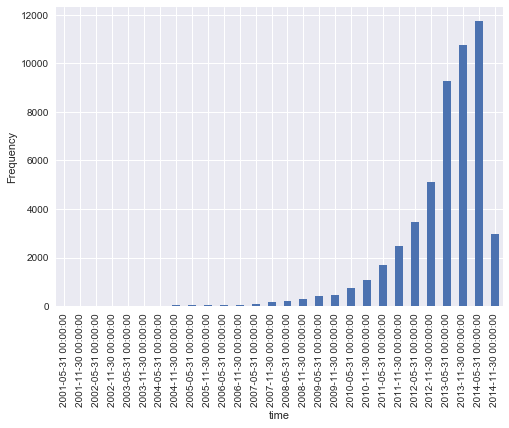

In [20]:
plt.figure()
df.set_index('time')['price'].groupby(pd.TimeGrouper(freq='6M')).count().plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

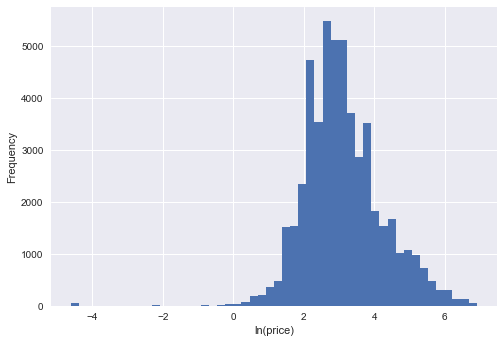

In [29]:
plt.figure()
np.log(df['price']).plot.hist(bins = 50,)
plt.xlabel('ln(price)')
plt.show()

In [30]:
df = df[df['time'] > '2013-01-01']
df.shape
#33378

(33378, 4)

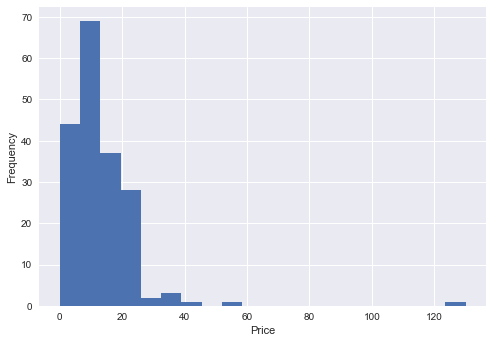

In [44]:
plt.figure()
df[df.apply(lambda x: 'sock' in x['title'].lower(), axis = 1)]['price'].plot.hist(bins = 20)
plt.xlabel('Price')
plt.show()

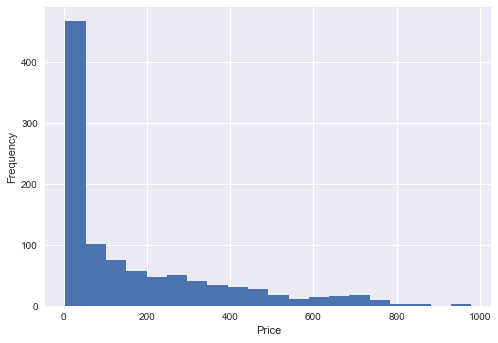

In [49]:
plt.figure()
df[df.apply(lambda x: 'stroller' in x['title'].lower(), axis = 1)]['price'].plot.hist(bins = 20)
plt.xlabel('Price')
plt.show()

In [52]:
import nltk
from nltk.collocations import *
from nltk.corpus import stopwords
words = nltk.word_tokenize(' '.join(df['title']))
print(len(words))
stopset = set(stopwords.words('english'))
bigram_measures = nltk.collocations.BigramAssocMeasures()
filtered_words = [w for w in words if not w in stopwords.words('english')]
print(len(filtered_words))

360191
344911


In [53]:
import string
filtered_words = [x for x in filtered_words if x not in string.punctuation]
print(len(filtered_words))

293700


In [54]:
finder = BigramCollocationFinder.from_words(filtered_words)
finder.nbest(bigram_measures.raw_freq, 20)

[('Bedding', 'Set'),
 ('Car', 'Seat'),
 ('Diaper', 'Bag'),
 ('2', 'Pack'),
 ('Carter', "'s"),
 ('Crib', 'Bedding'),
 ('Jojo', 'Designs'),
 ('Sweet', 'Jojo'),
 ('Cloth', 'Diaper'),
 ('Summer', 'Infant'),
 ('One', 'Size'),
 ('BPA', 'Free'),
 ('Safety', '1st'),
 ('Changing', 'Pad'),
 ('Crib', 'Sheet'),
 ('Lambs', 'amp'),
 ('amp', 'Ivy'),
 ('3', 'Pack'),
 ('Gift', 'Set'),
 ('4', 'Piece')]

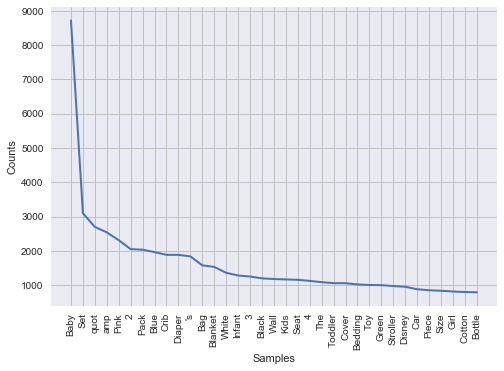

In [58]:
word_fd = nltk.FreqDist(filtered_words)
word_fd.plot(35,cumulative=False)

In [59]:
words_only = [w for w in filtered_words if w.isalpha()]
unique = set([w.lower() for w in words_only])
len(unique)

13978

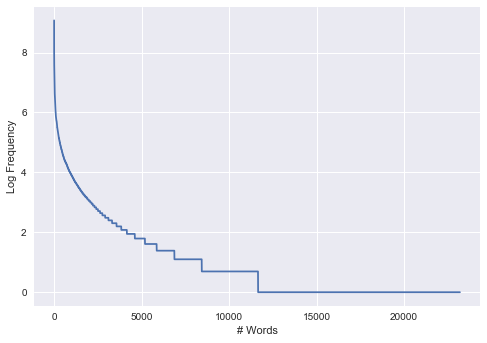

In [60]:
word_fd = nltk.FreqDist(filtered_words)
plt.figure()
plt.plot(list(range(len(word_fd))),np.log(sorted(word_fd.values(),reverse = True)))
plt.xlabel('# Words')
plt.ylabel('Log Frequency')
plt.show()

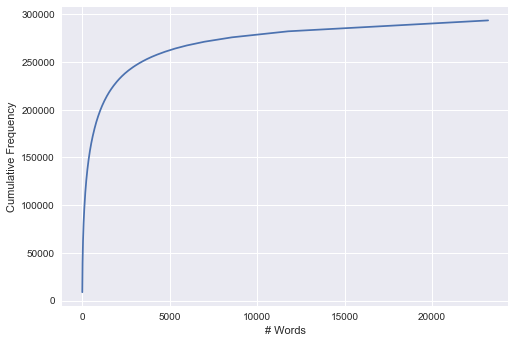

In [61]:
word_fd = nltk.FreqDist(filtered_words)
plt.figure()
plt.plot(list(range(len(word_fd))),np.array(sorted(word_fd.values(),reverse = True)).cumsum())
plt.xlabel('# Words')
plt.ylabel('Cumulative Frequency')
plt.show()

In [63]:
df = img_feat.set_index('rcnn_image_features.csv').merge(df, how = 'inner', left_index = True, right_index = True).dropna(how = 'any')

In [64]:
price = df['price']
rating = df['overall']
df = df.drop(['price','overall','time'],axis = 1)

In [65]:
del img_feat

In [66]:
df.shape

(33378, 4097)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer(analyzer = 'word', tokenizer = nltk.word_tokenize
                , stop_words = 'english', max_features = 1000)

In [68]:
from scipy.sparse import hstack
allFeatures = hstack((df.drop('title',axis = 1).values, countvect.fit_transform(df['title'])))

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(allFeatures,price, test_size = 0.2, random_state = 1)

In [62]:
gb = GradientBoostingRegressor(random_state = 1, n_estimators = 100)
param_grid = {'learning_rate': [0.01, 0.1, 1, 10],
             'max_depth': [3,5, 7]}

In [63]:
gs = GridSearchCV(estimator = gb, param_grid = param_grid, scoring = 'r2', cv = 3, n_jobs = 3, verbose = 10).fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 10.2min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 51.2min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 61.0min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 110.7min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 149.9min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 201.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:672: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


In [64]:
import pickle
pickle.dump(gs, open('gsgd','wb'))

In [65]:
gs = pickle.load(open('gsgd','rb'))

In [67]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,566.670623,0.114586,2.786318e-01,3.243149e-01,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",6,2.746436e-01,3.206852e-01,2.756077e-01,3.257986e-01,2.856449e-01,3.264610e-01,0.880525,7.364516e-03,0.004974,0.002581
1,986.255134,0.119795,3.309793e-01,4.812772e-01,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",5,3.311018e-01,4.812723e-01,3.247332e-01,4.761615e-01,3.371035e-01,4.863977e-01,1.923422,7.367271e-03,0.005051,0.004179
2,1485.886665,0.145834,3.545946e-01,5.994504e-01,0.01,7,"{'learning_rate': 0.01, 'max_depth': 7}",4,3.550735e-01,6.018290e-01,3.471884e-01,5.952919e-01,3.615226e-01,6.012302e-01,7.834503,7.365808e-03,0.005862,0.002951
3,562.740034,0.114584,4.494290e-01,6.398482e-01,0.1,3,"{'learning_rate': 0.1, 'max_depth': 3}",3,4.584442e-01,6.370217e-01,4.378416e-01,6.420067e-01,4.520016e-01,6.405162e-01,0.943872,7.366033e-03,0.008606,0.002089
4,989.149054,0.139613,4.848307e-01,8.158985e-01,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",2,4.922831e-01,8.141078e-01,4.711908e-01,8.157892e-01,4.910190e-01,8.177984e-01,0.990014,1.433218e-03,0.009659,0.001509
5,1452.639853,0.145834,4.886593e-01,9.063788e-01,0.1,7,"{'learning_rate': 0.1, 'max_depth': 7}",1,4.976960e-01,9.064331e-01,4.791010e-01,9.076069e-01,4.891809e-01,9.050965e-01,4.112546,7.365639e-03,0.007600,0.001026
6,565.015646,0.120319,1.792066e-02,8.619998e-01,1,3,"{'learning_rate': 1, 'max_depth': 3}",7,4.932588e-02,8.617218e-01,-3.529163e-02,8.642543e-01,3.973017e-02,8.600232e-01,0.675001,7.765183e-03,0.037831,0.001738
7,970.525649,0.140625,-1.198566e-01,9.623524e-01,1,5,"{'learning_rate': 1, 'max_depth': 5}",8,-1.098837e-01,9.611571e-01,-1.242398e-01,9.622157e-01,-1.254470e-01,9.636842e-01,0.890323,3.893359e-07,0.007069,0.001036
8,1368.443473,0.145834,-1.649937e-01,9.907511e-01,1,7,"{'learning_rate': 1, 'max_depth': 7}",9,-1.382360e-01,9.904348e-01,-2.061176e-01,9.913164e-01,-1.506260e-01,9.905020e-01,5.178201,7.365527e-03,0.029516,0.000401
9,563.856970,0.104178,-1.796564e+190,-1.918447e+190,10,3,"{'learning_rate': 10, 'max_depth': 3}",10,-1.592175e+190,-1.868740e+190,-1.839157e+190,-1.942958e+190,-1.958380e+190,-1.943643e+190,1.106056,7.351815e-03,inf,inf


In [70]:
gb = GradientBoostingRegressor(random_state = 1, n_estimators = 100)
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'max_depth': [8, 10, 13]}

In [ ]:
gs2 = GridSearchCV(estimator = gb, param_grid = param_grid, scoring = 'r2', cv = 3, n_jobs = 3, verbose = 10).fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
